<a href="https://colab.research.google.com/github/fnsalamaa/Machine-Learning/blob/main/Machine_Learning_Week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**✩˚｡⋆ WEEK 10 MACHINE LEARNING ✩˚｡⋆**
## Name : Fina Salama Qowlam Hareny
### No  : 08 / 2141720164
### Class : TI-3I

----
###**⋰˚☆LAB WORK 1⋰˚☆**
###RNN for Sentiment Analysis

**Step 1 : Import matplotlib and create a helper function to plot the graph:**


In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

**Step 2 - Setup input pipeline**

The IMDB movie review dataset is a binary classification dataset—all reviews have either positive or negative sentiment.
Download the dataset using TFDS. See loading text tutorial if you want to load the data manually

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially, this returns a dataset (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next, shuffle the data for training and create this pair dataset:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"There is no denying that Ealing comedies are good, but for me this film stands out as one of the best.<br /><br />The basic premise of the film is that a small part of Pimlico in London is discovered to be part of Burgundy, not the UK. We then follow the lives of the residents in their battle to keep the treasure found after the bomb explodes, and keep out the black market traders who soon realise that being exempt from UK law, rationing does not exist. When they become prisoners in their own street because the government has decided to close the boarder we see them fight back against the system.<br /><br />They are forced to ration water and food in their stand for what is right. In fact becoming worse off than they were before it all started, that's where the moral comes in. It's when they loose all the food that they think they are beaten and call for a surrender, only to have the whole of London respond to their plight by sending food, lot's of it. Thus enabling them to 

**Step 3 - Create a Text Encoder**
Raw text loaded by tfds needs to be processed before it can be used in a model. The easiest way to preprocess text for training is to use the TextVectorization layer. This layer has many capabilities, but in this tutorial, we are using the default behavior. Create this layer and pass the text dataset to the layer's .adapt method:


In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. The first 20 tokens can be seen with the following code. After padding and unknown tokens, they are sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The index tensor is padded with 0s to the longest sequence in the batch (unless if you set output_sequence_length fixed):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 48,   7,  57, ...,   0,   0,   0],
       [ 11,  14, 154, ...,   0,   0,   0],
       [  2,   1,  14, ...,   0,   0,   0]])

With the default settings, the process cannot be fully reversed. There are two main reasons for this:
- The default value for the standardization argument of preprocessing.TextVectorization is "lower_and_strip_punctuation".
- The limited vocabulary size and the lack of character-based fallback result in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"There is no denying that Ealing comedies are good, but for me this film stands out as one of the best.<br /><br />The basic premise of the film is that a small part of Pimlico in London is discovered to be part of Burgundy, not the UK. We then follow the lives of the residents in their battle to keep the treasure found after the bomb explodes, and keep out the black market traders who soon realise that being exempt from UK law, rationing does not exist. When they become prisoners in their own street because the government has decided to close the boarder we see them fight back against the system.<br /><br />They are forced to ration water and food in their stand for what is right. In fact becoming worse off than they were before it all started, that's where the moral comes in. It's when they loose all the food that they think they are beaten and call for a surrender, only to have the whole of London respond to their plight by sending food, lot's of it. Thus enabling them t

**Step 4 - Create a Model**

The model diagram can be seen in the image above:
1. This model can be created as tf.keras.Sequential.
2. The first layer is the encoder, which converts text into a sequence of token indices.
3. Following the encoder is the embedding layer. The embedding layer stores one vector per word. When called, it transforms a sequence of word indices into a sequence of vectors. These vectors can be trained. After training (with enough data), words with similar meanings often have similar vectors. This indexing operation is much more efficient than equivalent operations performed on one-hot encoded vectors passed through a tf.keras.layers.Dense layer.
4. The Recurrent Neural Network (RNN) processes the input sequence by iterating through its elements. The RNN passes the output from one time step to its input in the next time step. A tf.keras.layers.Bidirectional wrapper can also be used with the RNN layer. This propagates the input forward and backward through the RNN layer and then combines the final output. The main advantage of bidirectional RNNs is that signals from the beginning of the input do not have to be processed all the way through to affect the output. The main disadvantage of bidirectional RNNs is that you cannot perform efficient streaming predictions as words are added at the end.
5. After the RNN converts the sequence to a single vector, both Dense layers perform some final processing, and convert this vector representation into a single logit as the classification output.

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that a Keras Sequential model is used here because all the layers in the model have a single input and produce a single output. If you want to use stateful RNN layers, you might want to build your model using the Keras functional API or model subclassing so you can capture and reuse the state of RNN layers. For details, you can refer to the Keras RNN guide.

The embedding layer uses masking (uses masking) to handle varying sequence lengths. All layers after the embedding support masking.

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To ensure this works as expected, evaluate a sentence twice. First, a single sentence with no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.01561446]


Now, evaluate again in a batch with longer sentences. The result should be the same:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 78ms/step
[0.01561447]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Step 5 - Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 98ms/step - loss: 0.6361 - accuracy: 0.5859 - val_loss: 0.4795 - val_accuracy: 0.7734
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4023 - accuracy: 0.8186 - val_loss: 0.3695 - val_accuracy: 0.8438
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3404 - accuracy: 0.8488 - val_loss: 0.3429 - val_accuracy: 0.8484
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3216 - accuracy: 0.8602 - val_loss: 0.3330 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3157 - accuracy: 0.8640 - val_loss: 0.3529 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3082 - accuracy: 0.8668 - val_loss: 0.3305 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3049 - accuracy: 0.8676 - val_loss: 0.3229 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3154 - accuracy: 0.8577
Test Loss: 0.3154299259185791
Test Accuracy: 0.8577200174331665


(0.0, 0.6528135344386101)

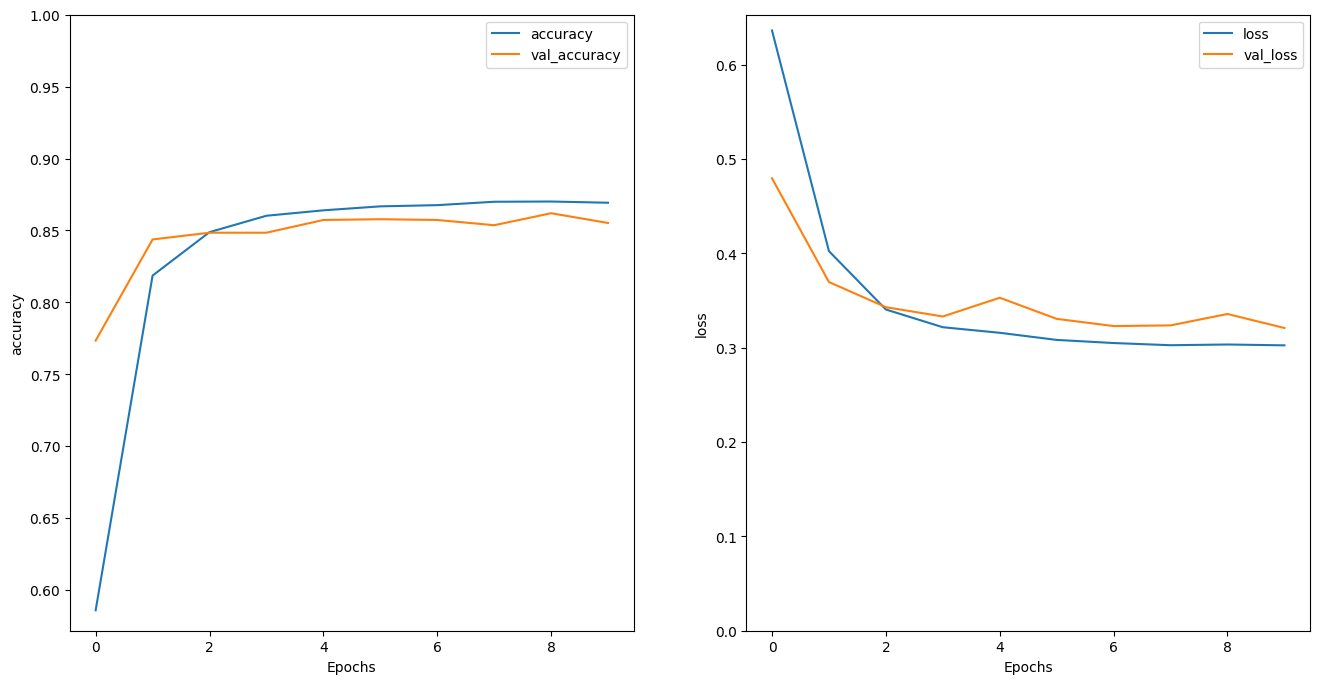

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run predictions on a new sentence: If the prediction is >= 0.0, it's positive; otherwise, it's negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


Keras RNN layers have two modes available, which are controlled by the return_sequences constructor argument:
- If False, it only returns the last output for each input sequence (a 2D tensor shape (batch_size, output_features)). This is the default used in the previous model.
- If True, it returns the full sequence of outputs for each time step (a 3D tensor shape (batch_size, time_steps, output_features)).

Here is the information flow with return_sequences=True:

One interesting aspect of using RNNs with return_sequences=True is that the output still has 3 axes, just like the input, so it can be passed to other RNN layers, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 77s 149ms/step - loss: 0.6156 - accuracy: 0.5979 - val_loss: 0.4338 - val_accuracy: 0.8167
Epoch 2/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3883 - accuracy: 0.8300 - val_loss: 0.3525 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3377 - accuracy: 0.8538 - val_loss: 0.3363 - val_accuracy: 0.8526
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3206 - accuracy: 0.8616 - val_loss: 0.3266 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 45s 113ms/step - loss: 0.3122 - accuracy: 0.8664 - val_loss: 0.3315 - val_accuracy: 0.8458
Epoch 6/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3065 - accuracy: 0.8706 - val_loss: 0.3194 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3076 - accuracy: 0.8690 - val_loss: 0.3349 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3239 - accuracy: 0.8430
Test Loss: 0.3239414393901825
Test Accuracy: 0.842960000038147


In [ ]:
# predict on a sample text without padding.
# Assuming encoder is your text encoder
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Predict on the preprocessed sample text
predictions = model.predict(np.array([sample_text]))
print(predictions)


1/1 [==============================] - 6s 6s/step
[[-2.1635895]]


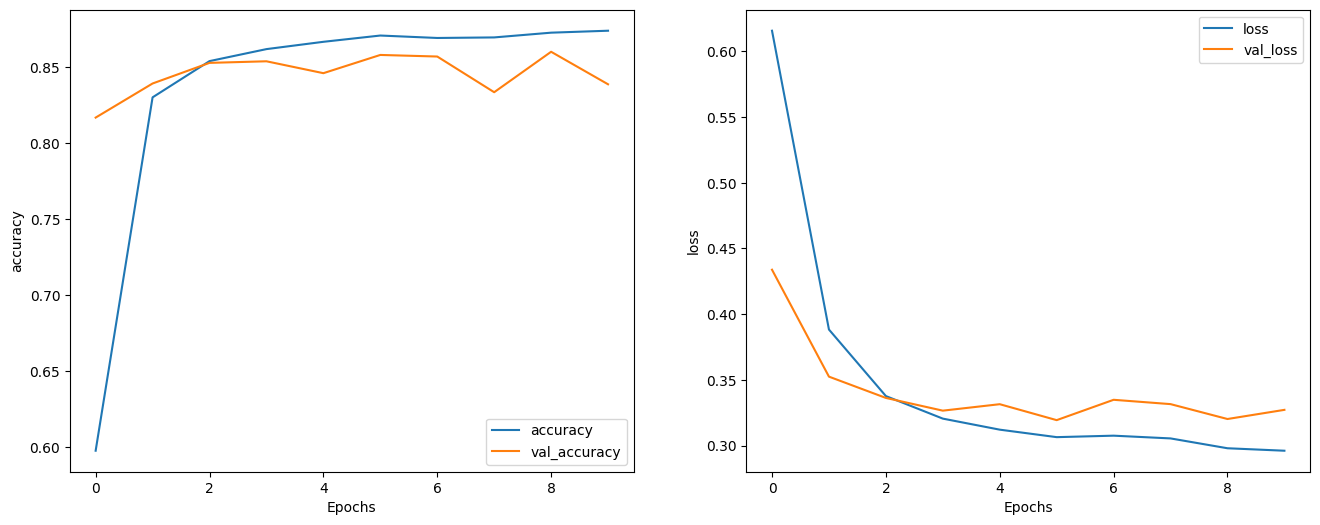

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

----
###**⋰˚☆LAB WORK 2⋰˚☆**
###Text Generator with RNN
This lab demonstrates how to perform text generation using an RNN. The dataset used is Shakespeare's writing from Andrej Karpathy's The Unreasonable Effectiveness of Recurrent Neural Networks. Given a sequence of characters from this data ('Shakespear'), train a model to predict the next character in the sequence ('e'). Longer text sequences can be generated by repeatedly calling the model.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: Runtime > Change runtime type > Hardware accelerator > GPU.

This tutorial uses tf.keras and eager execution. Here is an example output when the model in this tutorial is trained for 30 epochs, starting with the prompt 'Q':

**Step 1 - Setup**

In [ ]:
# Import TenserFlow
import tensorflow as tf
import numpy as np
import os
import time

**Step 2 - Download Dataset Shakespeare**

In [ ]:
# Adjust to the location of the data you have.
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


**Step 3 - Load Data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Text Processing**

**Step 1 - Vectorize Text**

Before training, you need to convert the string into a numeric representation. tf.keras.layers.StringLookup can convert each character to a numeric ID. The way this is done is by first breaking the text into tokens.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')

Now create the tf.keras.layers.StringLookup layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)


The above command converts tokens into IDs.

In [ ]:
ids = ids_from_chars(chars)
print(ids)

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>


Since the goal of this tutorial is to generate text, it's also important to reverse this representation. For this, you can use the tf.keras.layers.StringLookup(..., invert=True) code.

Note: In this code, instead of passing the original vocabulary generated with sorted(set(text)), use the get_vocabulary() method from tf.keras.layers.StringLookup so that the [UNK] token is set in the same way.

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

This layer converts characters back from the ID vector and returns them as a tf.RaggedTensor:

In [ ]:
chars = chars_from_ids(ids)
chars


<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

You can use tf.strings.reduce_join to recombine characters into a string.

In [ ]:
result = tf.strings.reduce_join(chars, axis=-1).numpy()
print(result)

[b'abcdefg' b'xyz']


**Step 2 - Prediction**

Given a character, or a sequence of characters, what is the most likely next character? This is the task that you need to train the model to perform. The input to the model will be a sequence of characters, and you train the model to predict the output as the next character at each time step. Since the RNN maintains an internal state that depends on the elements seen so far, given all the characters computed thus far, what is the next character?

**Step 3 - Creating the Training Set and Target**

Next, divide the text into example sequences. Each input sequence will contain seq_length characters from the text. For each input sequence, the target prediction contains the text with the same length, but shifted one character to the right. So, split the text into seq_length+1 parts. For example, if seq_length is 4 and your text is "Hello," the input sequence is "Hell," and the target sequence is "ello." To do this, first use the tf.data.Dataset.from_tensor_slices function to convert the text vector into a stream of character indices.

In [ ]:
# Convert the text to token IDs using ids_from_chars layer
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
print(all_ids)


tf.Tensor([19 48 57 ... 46  9  1], shape=(1115394,), dtype=int64)


In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

The batch method allows you to easily convert these individual characters into a desired size sequence.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It will be easier to see what this does if you recombine the tokens back into a string: